# Predict Maintenance of Industrial Machines

In [11]:
%pip install xgboost imblearn numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, f1_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb

In [2]:
# set base url of datasets
base_url = './dataset/preprocessed/'

# Load preprocessed data
X_train = pd.read_csv(f'{base_url}X_train.csv')
X_test = pd.read_csv(f'{base_url}X_test.csv')
y_train = pd.read_csv(f'{base_url}y_train.csv')
y_test = pd.read_csv(f'{base_url}y_test.csv')

# change y to series if it's a dataframe
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0]

print(X_train.count())

# Handle class imbalance with SMOTE
# what is smote ? 
# SMOTE generates new samples not duplicate samples.
# It does this by interpolating between a minority class sample and one of its nearest neighbors.
# It use k nearest neighbors method
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(X_train_resampled.count())

Air temperature _K_        8000
Process temperature _K_    8000
Rotational speed _rpm_     8000
Torque _Nm_                8000
Tool wear _min_            8000
Type_L                     8000
Type_M                     8000
dtype: int64
Air temperature _K_        15458
Process temperature _K_    15458
Rotational speed _rpm_     15458
Torque _Nm_                15458
Tool wear _min_            15458
Type_L                     15458
Type_M                     15458
dtype: int64


In [3]:
# train data with Logistic Regression model
# max iter is max duplicate the train process that help model find best answer
# we used class_weight='balanced' when data is imbalanced that help to give more weight to the least classes
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_resampled, y_train_resampled)

feature_names = X_train.columns

# Get features importance (weights)
lr_coefficients = lr_model.coef_[0]
# Create a new data frame & implement each feature with weight
lr_importances = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_coefficients
})

# sort data from maximum to minimum base on weights
lr_importances = lr_importances.reindex(
    lr_importances['Coefficient'].abs().sort_values(ascending=False).index)

lr_importances.head()

,Feature,Coefficient
3,Torque _Nm_,2.522511
0,Air temperature _K_,1.963943
2,Rotational speed _rpm_,1.804496
1,Process temperature _K_,-1.403247
4,Tool wear _min_,0.918044


In [4]:
# train data with Random Forest model
# n_estimators is the count of trees in every forest
# max depth is every tree depth
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train_resampled, y_train_resampled)

# Get RF feature importance
rf_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
})
rf_importances = rf_importances.sort_values('Importance', ascending=False)

rf_importances.head()

,Feature,Importance
3,Torque _Nm_,0.315830
2,Rotational speed _rpm_,0.287347
4,Tool wear _min_,0.198923
0,Air temperature _K_,0.092600
1,Process temperature _K_,0.051380


In [5]:
# train data with XGBoost model

# calculate the positive samples (failure machines)
pos_count = sum(y_train_resampled == 1)
# calculate the negative samples (safe machines)
neg_count = sum(y_train_resampled == 0)
# the ratio of healthy to broken machines
scale_pos_weight = neg_count / pos_count

# we calculate scale_pos_weight for managing imbalanced data
# n_estimators is count of trees
# max_depth is maximum depth of each tree
# we will increase the weight of least targets by scale_pos_weight

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Get XGB feature importance
xgb_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
})
xgb_importances = xgb_importances.sort_values('Importance', ascending=False)

xgb_importances.head()

,Feature,Importance
2,Rotational speed _rpm_,0.350632
3,Torque _Nm_,0.222934
4,Tool wear _min_,0.198539
0,Air temperature _K_,0.070590
5,Type_L,0.057989


In [6]:
# Model predictions
lr_pred = lr_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# This method returns the probability of each sample belonging to each class instead of a definitive answer.
lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate models - create metrics
# create models dictionary that include probability and definitive answers for each model
models = {
    'Logistic Regression': (lr_pred, lr_pred_proba),
    'Random Forest': (rf_pred, rf_pred_proba),
    'XGBoost': (xgb_pred, xgb_pred_proba)
}

results = {}
# loop on models answers and calculate the measurements of each models and save results as a dictionary
for model_name, (y_pred, y_pred_proba) in models.items():
    results[model_name] = {
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_pred_proba)
    }

In [7]:
# save the results dictionary as a df
# we will rotate the dataframe with .T (change the place of rows and columns)
metrics_df = pd.DataFrame(results).T
# This method rounds all the numbers in the df to three decimal places.
metrics_df = metrics_df.round(3)

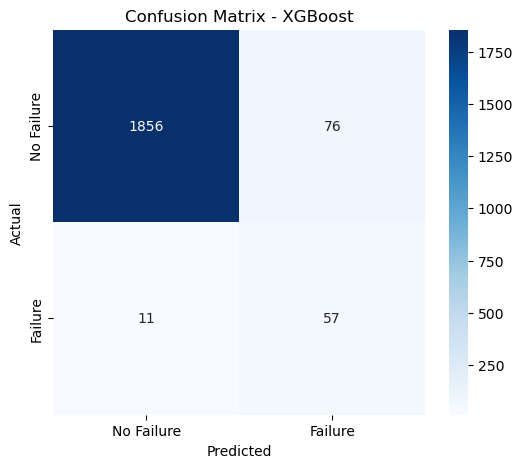

In [ ]:
# Plot confusion matrix for XGBoost model
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, xgb_pred)
# fmt d mean show numbers as integer
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Failure', 'Failure'],
            yticklabels=['No Failure', 'Failure'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')

# save the plot
plt.savefig('./plots/confusion_matrix_xgboost.png')

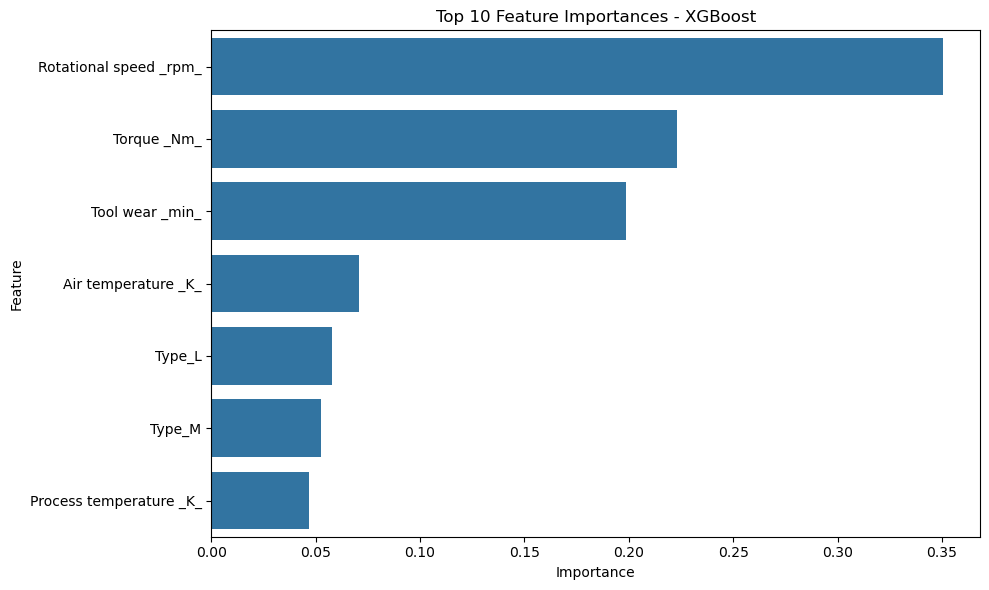

In [13]:
# Plot feature importance for the best model
plt.figure(figsize=(10, 6))
top_features = xgb_importances.head(10)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 10 Feature Importances - XGBoost')
plt.tight_layout()

# save the plot
plt.savefig('./plots/top_ten_features_important.png')

Model Performance Comparison:
                     recall  precision     f1    auc
Logistic Regression   0.824      0.145  0.247  0.908
Random Forest         0.779      0.398  0.527  0.966
XGBoost               0.838      0.429  0.567  0.973

Top 5 Most Important Features (XGBoost):
                  Feature  Importance
2  Rotational speed _rpm_    0.350632
3             Torque _Nm_    0.222934
4         Tool wear _min_    0.198539
0     Air temperature _K_    0.070590
5                  Type_L    0.057989


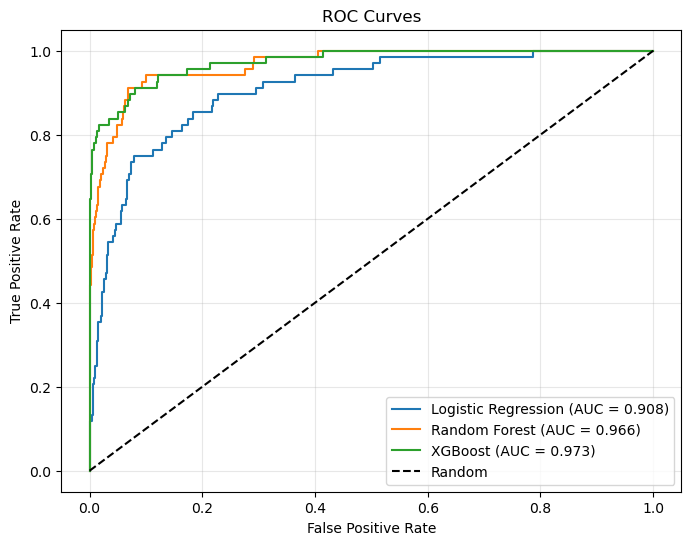

In [14]:
# plot ROC curves for all models
plt.figure(figsize=(8, 6))
for model_name, (y_pred, y_pred_proba) in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# display model comparison
print("Model Performance Comparison:")
print(metrics_df)

# print top 5 most important features
print("\nTop 5 Most Important Features (XGBoost):")
print(xgb_importances[['Feature', 'Importance']].head(5))

# save the result plot

plt.savefig('./plots/ROC_Curves.png')